In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opencv-contrib-python


In [4]:
!pip install google-cloud-vision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 4.4 MB/s eta 0:00:00


In [5]:
!pip install utils


"UWELL
• 주민등록증
박현식(朴)
960709-1148415
경기도 부천시 상동로 186. 2
127동 1202호 (상동 다정
한마을)
2020 7 13
ㄹㅊ
경기도 부천시장 시장의
OL
Only
SODA BLUE
THE LAST STATION
VALYRIAN MAX POD SYSTEM"

"UWELL"

"•"

"주민등록증"

"박현식"

"("

"朴"

")"

"960709-1148415"
주민등록번호: 9607091148415
성인 주민등록번호: 960709-1148415, 나이: 27


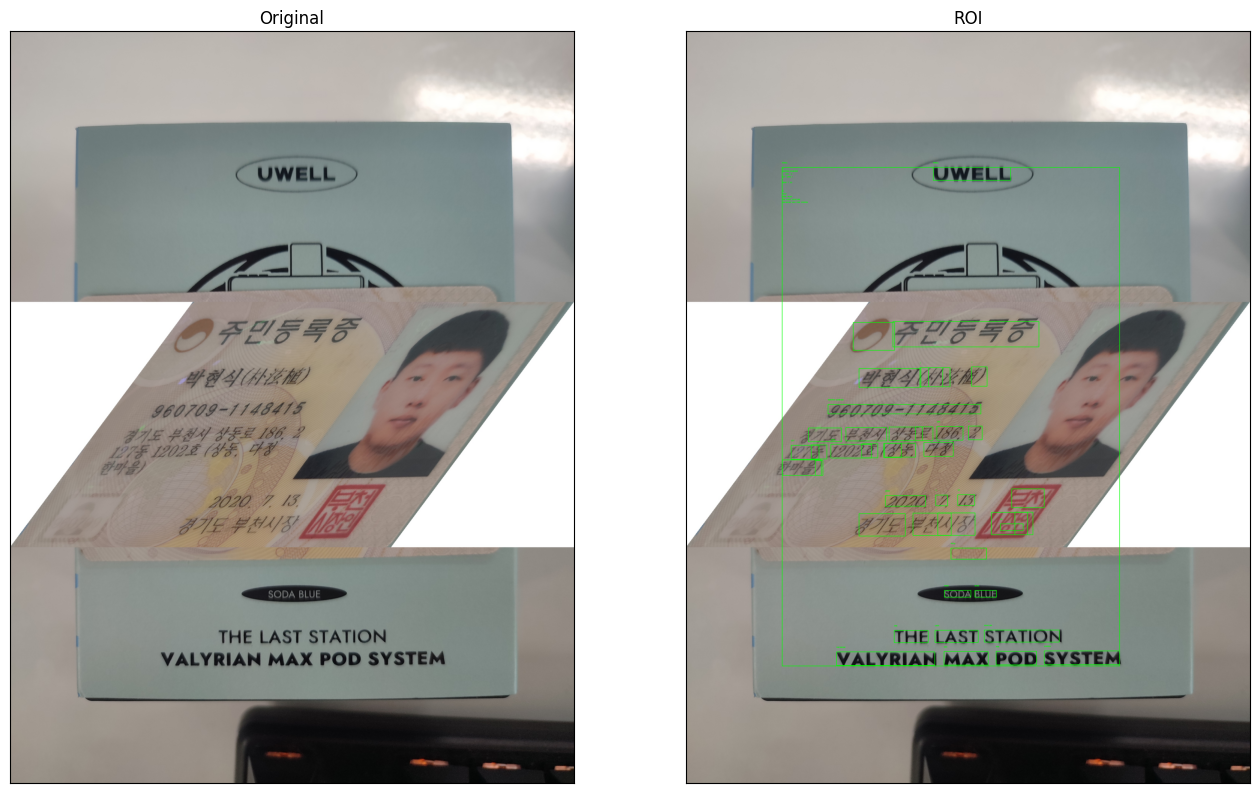

In [11]:
import cv2
import numpy as np
from datetime import datetime
from google.cloud import vision
from PIL import Image, ImageDraw, ImageFont
import io
import os

# 만 나이와 성인 여부를 계산하는 함수
def calculate_age_and_is_adult(registered_number):
    # 주민등록번호 유효성 검사
    if len(registered_number) != 13 or not registered_number.isdigit():
        raise ValueError("Invalid registered number format.")

    # 생년월일 추출
    year_born = int(registered_number[:2])
    month_born = int(registered_number[2:4])
    date_born = int(registered_number[4:6])

    # 현재 연도, 월, 일 가져오기
    now = datetime.now()
    year_int = int(now.strftime('%Y'))
    month_int = int(now.strftime('%m'))
    date_int = int(now.strftime('%d'))

    # 생년월일을 기반으로 만 나이 계산
    age = year_int - (1900 + year_born) + 1
    if month_int < month_born or (month_int == month_born and date_int < date_born):
        age -= 1

    # 성인 여부 판별
    is_adult = age >= 19

    return age, is_adult

# 구글 비전 API 서비스 계정 키 파일 경로
service_account_path = "/content/drive/MyDrive/데분팀/0731/service-account-file.json"

# 환경 변수에 구글 비전 API 서비스 계정 키 파일 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = service_account_path

# Vision API 클라이언트 객체 초기화
client = vision.ImageAnnotatorClient()

# 이미지 파일 경로
img_path = '/content/drive/MyDrive/데분팀/0731/1.jpg'

# 이미지 파일 읽기
with io.open(img_path, 'rb') as image_file:
    content = image_file.read()

# 이미지를 Vision API가 인식할 수 있는 형식으로 변환
image = vision.Image(content=content)

# Vision API를 사용하여 텍스트 인식 수행
response = client.text_detection(image=image)
texts = response.text_annotations

# 주민등록번호와 성인 여부를 저장할 변수 초기화
registered_number = None
is_adult = False

# 추출된 텍스트를 출력하면서 주민등록번호 추출
for text in texts:
    ocr_text = text.description
    print('\n"{}"'.format(ocr_text))  # ocr_text 값 확인

    # 주민등록번호 추출 후 성인 여부 판별
    extracted_number = ''.join(filter(str.isdigit, ocr_text))
    if len(extracted_number) == 13 and ocr_text.count('-') == 1:
        registered_number = extracted_number
        age, is_adult = calculate_age_and_is_adult(registered_number)
        break

# 주민등록번호가 추출되고 성인일 경우에만 결과 출력
if registered_number and is_adult:
    print(f"주민등록번호: {registered_number}")
    print(f"성인 주민등록번호: {ocr_text}, 나이: {age-1}")
else:
    print("주민등록번호가 추출되지 않거나 미성년자입니다.")

# 이미지에 ROI와 추출된 텍스트를 표시하여 출력
img = cv2.imread(img_path)
roi_img = img.copy()

for text in texts:
    ocr_text = text.description

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                for vertex in text.bounding_poly.vertices])

    x1 = text.bounding_poly.vertices[0].x
    y1 = text.bounding_poly.vertices[0].y
    x2 = text.bounding_poly.vertices[1].x
    y2 = text.bounding_poly.vertices[2].y

    cv2.rectangle(roi_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    roi_img = putText(roi_img, ocr_text, x1, y1 - 30, font_size=30)

plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))
